Тут само собой нужно было работать с NLP. Я выбрал LDA (Latent Dirichlet Allocation). Эта модель используется для выявления тем в коллекции текстов (в нашем случае отзывов покупателей). Основная идея LDA заключается в том, что каждое слово в документе связано с какой-то темой, и вероятность появления слова зависит от темы.

Ну и конечно же скажу сразу и честно, что я сам полностью не смог бы написать весь этот код, но всё же в рамках этого задания получил знания и практику. Опирался на сайт, где была похожая задача на мою (https://webdevblog.ru/tematicheskoe-modelirovanie-s-pomoshhju-gensim-python/). Датасет нашел на kaggle с американского маркетплейса Амазон.

In [ ]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
!pip install nltk
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

# Используем spacy для базовой предобработки, можно также использовать nltk (лемматизация и др.)
import spacy

# gensim для LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# график
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
#from pyLDAvis import gensim_models as pg
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# Загрузка датасета с отзывами о продуктах Amazon
df = pd.read_csv('/content/drive/MyDrive/7817_1.csv')
print(df.shape)
df.head()

(1597, 27)


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [ ]:
# Фильтрация по ID продукта (например, Amazon Echo)
df = df[df['asins']=="B01BH83OOM"]
print(df.shape)
df.head()

(542, 27)


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
852,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",IMPORTANT UPDATE (3/8/17): As you read my orig...,"The Echo's Little Sister Is AMAZING!! 3,",NaN,NaN,Deanokat,NaN,8.416670e+11,1.75 lbs
853,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",It was just a few weeks ago that I was bemoani...,Tap Alexa on the go!,NaN,NaN,Heather A,NaN,8.416670e+11,1.75 lbs
854,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",The Amazon Tap is a portable Bluetooth speaker...,Amazon Tap Review - Best Bluetooth Speaker in ...,NaN,NaN,Quentin Moore,NaN,8.416670e+11,1.75 lbs
855,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,Look at this product as a portable speaker fir...,Great for what it does,NaN,NaN,Casey,NaN,8.416670e+11,1.75 lbs
856,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,This Amazon tap is not only a great Bluetooth ...,"Awesome, smart little portable speaker",NaN,NaN,Tazman3582,NaN,8.416670e+11,1.75 lbs


In [ ]:
# Токенизация с использованием gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))


# Преобразование данных в список токенов
data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(data))

# Пример токенов
print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


In [ ]:
# создаем лист stop-word стоп-слов
nltk.download('stopwords')
stop_words = stopwords.words('english') + list(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Функции для удаления стоп-слов и лемматизации
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# remove stop words
data_words_nostops = remove_stopwords(data_words)

# Инициализация модели spaCy 'en'
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Лемматизация, оставляя только существительные, прилагательные, глаголы, наречия
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['look', 'product', 'portable', 'speaker', 'second', 'big', 'reason', 'buy', 'standard', 'wifi', 'streaming', 'enable', 'home', 'stream', 'music', 'ease', 'voice', 'recognition', 'top', 'notch', 'really', 'shine', 'use', 'smart', 'home', 'accessory', 'problem', 'tap', 'microphone', 'button', 'listen', 'voice', 'want', 'big', 'sound', 'always', 'listen', 'feature', 'spend', 'extra', 'money']


In [ ]:
# Сравнение версии без стоп-слов и лемматизированной с оригинальной версией
print(' '.join(data_words[3]), '\n')
print(' '.join(data_lemmatized[3]))

look at this product as portable speaker first and an echo replacement second the big reason to buy this over standard bluetooth speakers is this has wifi streaming enabled when you are at home you can stream music with ease to it voice recognition is top notch and it really shines when using it with other smart home accessories the only problem is having to tap the microphone button for it to listen to your voice if you want bigger sound and always listening features spend the extra money on the amazon echo 

look product portable speaker second big reason buy standard wifi streaming enable home stream music ease voice recognition top notch really shine use smart home accessory problem tap microphone button listen voice want big sound always listen feature spend extra money


In [ ]:
# Создание словаря
id2word = corpora.Dictionary(data_lemmatized)

# создание corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

print(corpus[2])

[(3, 2), (13, 2), (16, 2), (17, 3), (20, 2), (24, 4), (29, 1), (31, 1), (35, 1), (48, 2), (51, 1), (56, 1), (60, 5), (70, 1), (82, 1), (85, 5), (88, 1), (90, 2), (95, 1), (96, 1), (97, 2), (99, 2), (100, 1), (108, 2), (112, 1), (116, 1), (120, 1), (128, 2), (131, 1), (134, 1), (141, 1), (142, 1), (143, 2), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 2), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1), (163, 2), (164, 1), (165, 1), (166, 3), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 2), (180, 1), (181, 1), (182, 2), (183, 2), (184, 5), (185, 1), (186, 3), (187, 2), (188, 1), (189, 3), (190, 1), (191, 1), (192, 1), (193, 1), (194, 6), (195, 1), (196, 1), (197, 2), (198, 1), (199, 2), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 2), (207, 1), (208, 1), (209, 2), (210, 1)]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('admit', 1),
  ('alexa', 1),
  ('allow', 1),
  ('amazon', 1),
  ('announce', 1),
  ('answer', 1),
  ('anyway', 1),
  ('app', 2),
  ('appealing', 1),
  ('associate', 1),
  ('avid', 1),
  ('aware', 1),
  ('back', 1),
  ('battery', 3),
  ('buy', 1),
  ('choose', 2),
  ('command', 1),
  ('control', 1),
  ('convenience', 1),
  ('cook', 1),
  ('day', 1),
  ('decide', 2),
  ('demand', 1),
  ('development', 1),
  ('device', 3),
  ('dot', 1),
  ('drain', 1),
  ('early', 2),
  ('easily', 2),
  ('echo', 1),
  ('enable', 1),
  ('especially', 1),
  ('fabulous', 1),
  ('financial', 1),
  ('firmware', 1),
  ('first', 1),
  ('free', 6),
  ('get', 1),
  ('give', 1),
  ('go', 1),
  ('hand', 6),
  ('high', 1),
  ('hope', 1),
  ('important', 1),
  ('introduce', 1),
  ('keep', 1),
  ('kitchen', 1),
  ('lack', 1),
  ('life', 1),
  ('listener', 1),
  ('little', 2),
  ('lot', 1),
  ('love', 1),
  ('major', 1),
  ('make', 1),
  ('maximum', 1),
  ('microphone', 1),
  ('mind', 1),
  ('minimal', 1),
  ('mode',

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# print 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.068*"amazing" + 0.033*"easy" + 0.031*"little" + 0.030*"super" + '
  '0.026*"sync" + 0.024*"able" + 0.022*"beach" + 0.021*"weather" + '
  '0.017*"difficult" + 0.016*"assistant"'),
 (1,
  '0.061*"easy" + 0.057*"sound" + 0.043*"portability" + 0.038*"buy" + '
  '0.037*"echo" + 0.035*"feature" + 0.028*"house" + 0.028*"quality" + '
  '0.020*"need" + 0.020*"room"'),
 (2,
  '0.064*"loud" + 0.044*"decent" + 0.042*"expensive" + 0.035*"capability" + '
  '0.031*"glad" + 0.023*"upgrade" + 0.022*"mother" + 0.018*"issue" + '
  '0.015*"size" + 0.015*"online"'),
 (3,
  '0.043*"enjoy" + 0.039*"talk" + 0.033*"button" + 0.030*"alexa" + '
  '0.024*"thing" + 0.024*"fun" + 0.022*"put" + 0.021*"tap" + 0.020*"hold" + '
  '0.020*"lot"'),
 (4,
  '0.057*"great" + 0.048*"speaker" + 0.043*"use" + 0.037*"sound" + 0.035*"tap" '
  '+ 0.032*"love" + 0.031*"good" + 0.031*"music" + 0.028*"alexa" + '
  '0.026*"work"'),
 (5,
  '0.070*"set" + 0.037*"start" + 0.034*"actually" + 0.030*"radio" + '
  '0.027*"come" + 0

Coherence score - это метрика, используемая для оценки качества тематической модели, такой как Latent Dirichlet Allocation (LDA). Она предоставляет количественную меру того, насколько хорошо темы, выделенные моделью, интерпретируемы и связаны друг с другом.

Коэффициент когерентности рассчитывается на основе сравнения силы связей между словами внутри одной темы. Высокий коэффициент когерентности указывает на более четкие и интерпретируемые темы.

In [ ]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4395692084830964


Тут я тоже не смог решить эту ошибку. Там должен выйти график с окружностями. Смотреть дальше.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
# вычисляем значение связи
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):

    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics,
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))


    return model_list, coherence_values

In [ ]:

num_topics_range = [2, 6, 10, 15, 20]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        num_topics_range=num_topics_range,
                                                        alpha_range=alpha_range)

In [ ]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.495424
1,0.01,6,0.440773
2,0.01,10,0.407164
3,0.01,15,0.417828
4,0.01,20,0.406180
5,0.10,2,0.476269
6,0.10,6,0.428164
7,0.10,10,0.432584
8,0.10,15,0.408156
9,0.10,20,0.423234


In [ ]:
coherence_df.sort_values('coherence_value')

,alpha,num_topics,coherence_value
4,0.01,20,0.406180
2,0.01,10,0.407164
8,0.10,15,0.408156
3,0.01,15,0.417828
9,0.10,20,0.423234
6,0.10,6,0.428164
7,0.10,10,0.432584
1,0.01,6,0.440773
11,1.00,6,0.448491
12,1.00,10,0.463875


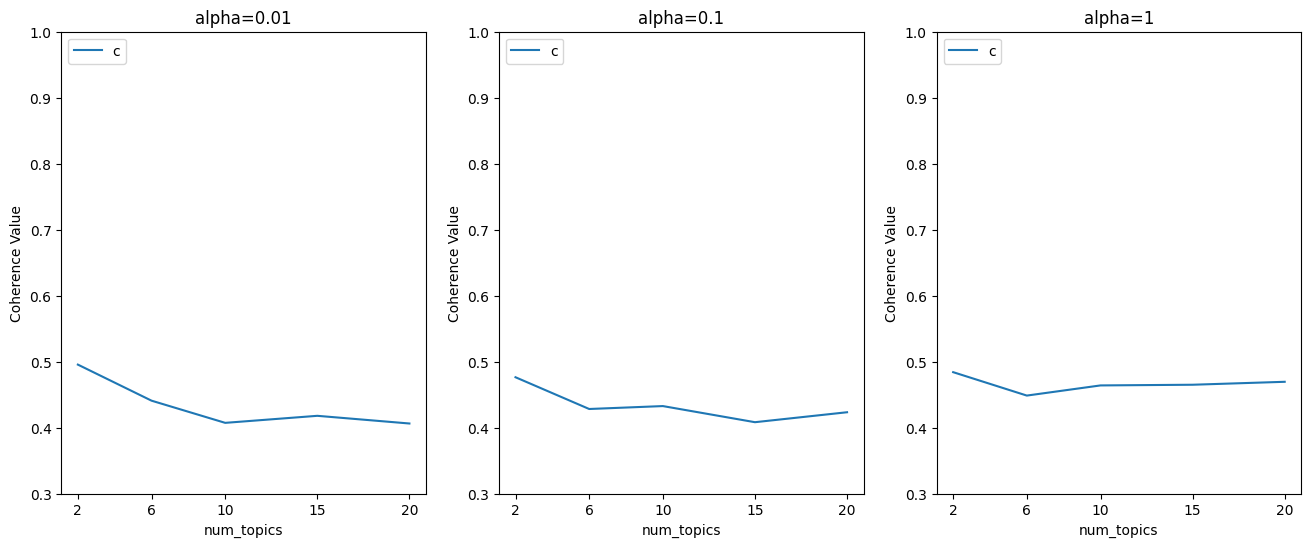

In [ ]:
# гпафик
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

plot_coherence(coherence_df, alpha_range, num_topics_range)

In [ ]:
#конечная модель LDA

Final_LDA_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=6,
                                                  random_state=100,
                                                  update_every=1,
                                                  chunksize=100,
                                                  passes=10,
                                                  alpha=1,
                                                  per_word_topics=True)

In [ ]:
pprint.pprint(Final_LDA_model.print_topics())
doc_lda = Final_LDA_model[corpus]

[(0,
  '0.068*"use" + 0.029*"enjoy" + 0.026*"able" + 0.023*"question" + '
  '0.021*"little" + 0.018*"hand" + 0.016*"app" + 0.015*"free" + 0.015*"ask" + '
  '0.014*"alexa"'),
 (1,
  '0.112*"sound" + 0.066*"great" + 0.057*"good" + 0.040*"quality" + '
  '0.026*"speaker" + 0.025*"easy" + 0.024*"well" + 0.023*"alexa" + '
  '0.018*"price" + 0.017*"portability"'),
 (2,
  '0.120*"love" + 0.078*"buy" + 0.048*"great" + 0.045*"use" + 0.042*"product" '
  '+ 0.040*"music" + 0.034*"play" + 0.025*"gift" + 0.016*"fun" + 0.015*"lot"'),
 (3,
  '0.057*"get" + 0.054*"tap" + 0.043*"portable" + 0.037*"work" + 0.036*"alexa" '
  '+ 0.034*"echo" + 0.031*"dot" + 0.030*"button" + 0.026*"speaker" + '
  '0.023*"listen"'),
 (4,
  '0.049*"speaker" + 0.027*"voice" + 0.025*"music" + 0.025*"connect" + '
  '0.024*"time" + 0.023*"phone" + 0.021*"wifi" + 0.020*"device" + 0.017*"say" '
  '+ 0.017*"also"'),
 (5,
  '0.073*"tap" + 0.022*"make" + 0.020*"purchase" + 0.019*"excellent" + '
  '0.017*"add" + 0.017*"even" + 0.015*"h

In [ ]:
# coherence score
coherence_model_lda = CoherenceModel(model=Final_LDA_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4320839187148216


In [ ]:
# Тут должна быть визуализация, но у меня почему-то не работает. Так и не смог найти решение.
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Final_LDA_model, corpus, id2word)
vis

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

Тут мы должны были увидеть примерно такой график, но я не смог решить ошибку. Окружности показали бы самые популярные товары и что о них пишут. Чем их больше и если они не пересекаются, то значит модель хорошая

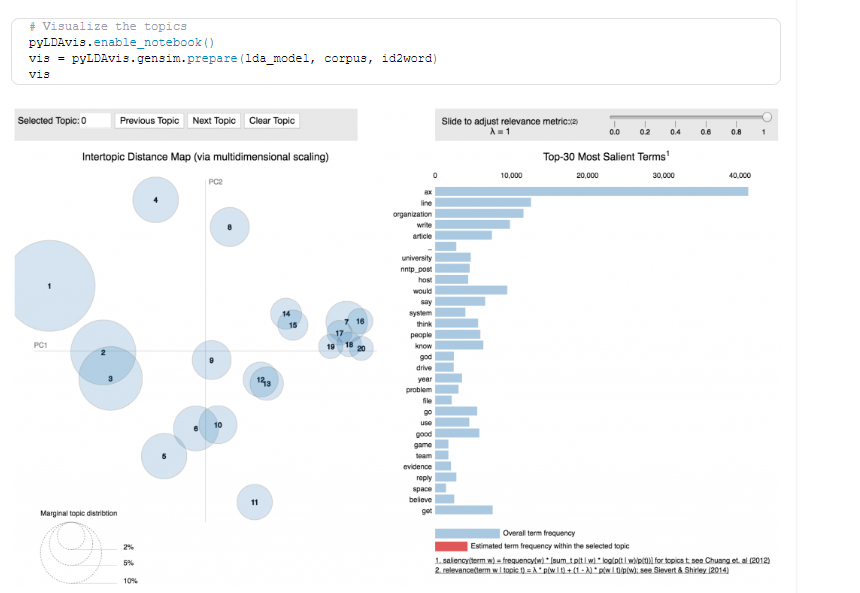